In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eolearn.core.eoworkflow import EOWorkflow, Dependency
from eolearn.core.eodata import FeatureType

In [3]:
from sentinelhub import BBox, CRS

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [5]:
from eolearn.core import LoadFromDisk, SaveToDisk, AddFeature
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.features import AddSpatioTemporalFeaturesTask, AddMaxMinTemporalIndicesTask, AddMaxMinNDVISlopeIndicesTask, AddTemporalDataFeaturesTask

from eolearn.features import SplineInterpolation

In [165]:
roi_bbox = BBox(bbox=[(4.7104, 52.8726), (4.7983, 52.9256)], crs=CRS.WGS84)
roi_bbox = BBox(bbox=[(4.71038818359375, 52.85905593845727), (4.798278808593751, 52.91204098150524)], crs=CRS.WGS84)
time_interval = ('2016-01-01', '2018-12-31')

In [107]:
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [170]:
LAYER_NAME = 'BANDS-S2-L1C'
FEATURE_NAME = 'BANDS-S2-L1C'

input_task = S2L1CWCSInput(layer=LAYER_NAME, 
                           resx='10m', resy='10m', 
                           maxcc=1, time_difference=datetime.timedelta(hours=2))

add_ndvi = S2L1CWCSInput(layer='NDVI')

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 
                           'BANDS-S2-L1C', 
                           cm_size_y='60m', 
                           cm_size_x='60m', 
                           cmask_feature='CLM',
                           cprobs_feature='CLP')

add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

add_maxmin_ndvi = AddMaxMinTemporalIndicesTask(mask_data=True)

add_maxmin_red = AddMaxMinTemporalIndicesTask(data_feature=LAYER_NAME, 
                                              data_index=3, 
                                              amax_data_feature='ARGMAX_B4',
                                              amin_data_feature='ARGMIN_B4',
                                              mask_data=True)

add_maxmin_ndvi_sl = AddMaxMinNDVISlopeIndicesTask()

add_stf = AddSpatioTemporalFeaturesTask()



interp_ndvi = SplineInterpolation((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'), spline_degree=3, smoothing_factor=0.1)


save = SaveToDisk('base_1y_artc')

Finished loading model, total used 170 iterations


In [174]:
workflow_with_interp = EOWorkflow.make_linear_workflow( input_task, add_ndvi, add_clm, add_valmask,save)
result = workflow_with_interp.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval}, save:{'eopatch_folder':'patch'}})

In [175]:
eopatch, = [result[key] for key in result.keys()]
eopatch

EOPatch(
  data: {
    BANDS-S2-L1C: <class 'numpy.ndarray'>, shape=(144, 589, 590, 13), dtype=float32
    CLP: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=float32
    NDVI: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=float32
  }
  mask: {
    CLM: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=uint8
    IS_DATA: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=uint8
    VALID_DATA: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=bool
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(0, 7200)
    time_interval: <class 'list'>, length=2
  }
  bbox: BBox(((4.71038818359375, 52.85905593845727), (4.798278808593751, 52.91204098150524)), crs=EPSG:4326)
  timestamp: <class 'list'>, length=144
)

In [10]:
load = LoadFromDisk('base_1y_artc')
workflow_load = EOWorkflow(dependencies=[Dependency(transform=load, inputs=[]),
                                        ])

In [11]:
from eolearn.features import BSplineInterpolation,KrigingInterpolation, LinearInterpolation, AkimaInterpolation
from eolearn.features.temporal_features import AddTemporalDataFeaturesTask

In [33]:
interp = BSplineInterpolation((FeatureType.DATA, 'NDVI'), mask_feature=(FeatureType.MASK, 'VALID_DATA'), 
                              resample_range=('2017-02-01', '2017-9-30', 1), 
                              copy_features=[(FeatureType.DATA, 'NDVI', 'NDVI_old'),
                                            (FeatureType.MASK, 'CLM'),
                                            (FeatureType.MASK, 'IS_DATA'),
                                            (FeatureType.MASK, 'VALID_DATA'),]
                              )


class ValidDataPredicateResample:
    def __call__(self, eopatch):
        return np.logical_not(np.isnan(eopatch.data['NDVI'].astype(np.bool)))
    
add_valmask_resample = AddValidDataMaskTask(predicate=ValidDataPredicateResample())
save_inter = SaveToDisk("interpolated_1y_2y_artc")

In [34]:
workflow_interp = EOWorkflow(dependencies=[Dependency(transform=load, inputs=[]),
                                           Dependency(transform=interp, inputs=[load]),
                                           Dependency(transform=add_valmask_resample, inputs=[interp]),
                                           #Dependency(transform=save_inter, inputs=[add_valmask_resample])
                                          ])

In [35]:
result_interp = workflow_interp.execute({load:{'eopatch_folder':'patch'}, save_inter:{'eopatch_folder':'patch'}})

HERE


In [36]:
burek = [result_interp[key] for key in result_interp.keys()]
patch_inter, = burek
patch_inter.data["NDVI"].shape, patch_inter.mask["VALID_DATA"].shape

((241, 589, 590, 1), (241, 589, 590, 1))

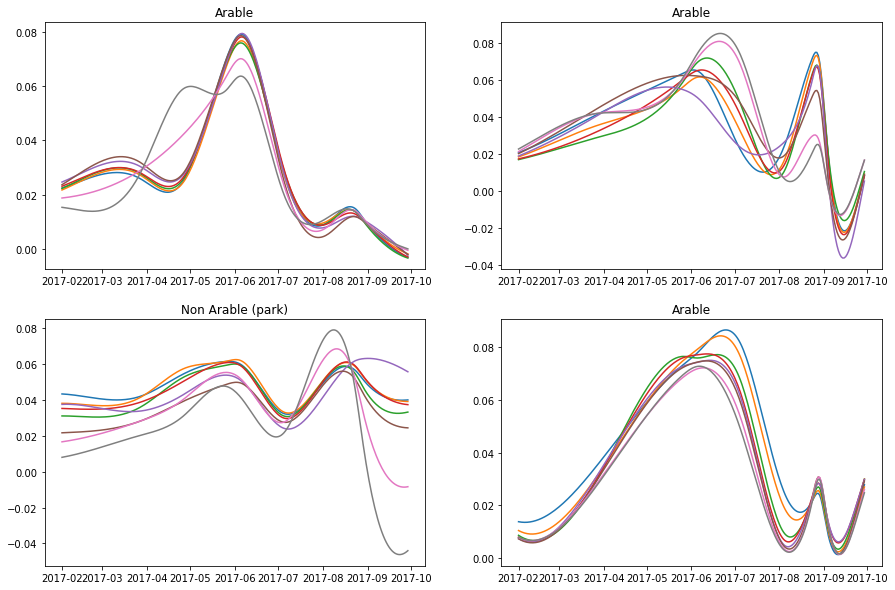

In [45]:
#pickle.dump((patch_inter.timestamp, patch_inter.data["NDVI"]), open("interpolated_ndvi_b_spline", "wb+"))
# BSpline
interesting = [[16, 16, 16, 16, 16, 16, 16, 16], [193, 194, 195, 196, 197, 198, 199, 200]]
interesting2 = [[40, 40, 40, 40, 40, 40, 40, 40], [323, 324, 325, 326, 327, 328, 329, 330]]# [[104, 104, 104, 104, 104, 104, 104, 104], [491, 492, 493, 494, 495, 496, 497, 498]]
interesting3 = [[193, 193, 193, 193, 193, 193, 193, 193], [141, 142, 143, 144, 145, 146, 147, 148]] # [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
interesting4 = [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
f = plt.figure(figsize=(15,10))
plt.title("Comparison of different NDVI curves")
plt.xticks(rotation=-30)
plt.subplot(221)
for x,y in zip(*interesting):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    plt.title("Arable")
    
plt.subplot(222)
for x,y in zip(*interesting2):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    plt.title("Arable")

plt.subplot(223)
for x,y in zip(*interesting3):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    plt.title("Non Arable (park)")

plt.subplot(224)
for x,y in zip(*interesting4):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    plt.title("Arable")

#plt.savefig("ndvi_time_plots_splines.png", bbox_inches="tight")

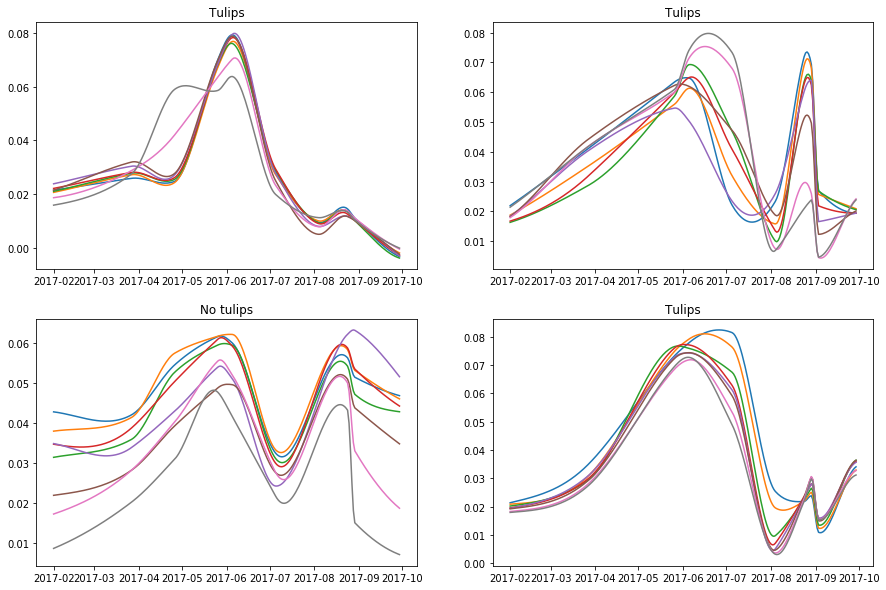

In [42]:
tss, datttt = pickle.load(open("interpolated_ndvi_akima", "rb+"))
# Akima
interesting = [[16, 16, 16, 16, 16, 16, 16, 16], [193, 194, 195, 196, 197, 198, 199, 200]]
interesting2 = [[40, 40, 40, 40, 40, 40, 40, 40], [323, 324, 325, 326, 327, 328, 329, 330]]# [[104, 104, 104, 104, 104, 104, 104, 104], [491, 492, 493, 494, 495, 496, 497, 498]]
interesting3 = [[193, 193, 193, 193, 193, 193, 193, 193], [141, 142, 143, 144, 145, 146, 147, 148]] # [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
interesting4 = [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
f = plt.figure(figsize=(15,10))
plt.subplot(221)
for x,y in zip(*interesting):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("Arable")
    
plt.subplot(222)
for x,y in zip(*interesting2):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("Arable")

plt.subplot(223)
for x,y in zip(*interesting3):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("Non Arable (park)")

plt.subplot(224)
for x,y in zip(*interesting4):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("Arable")
    
plt.savefig("ndvi_time_plots_akima.png", bbox_inches="tight")


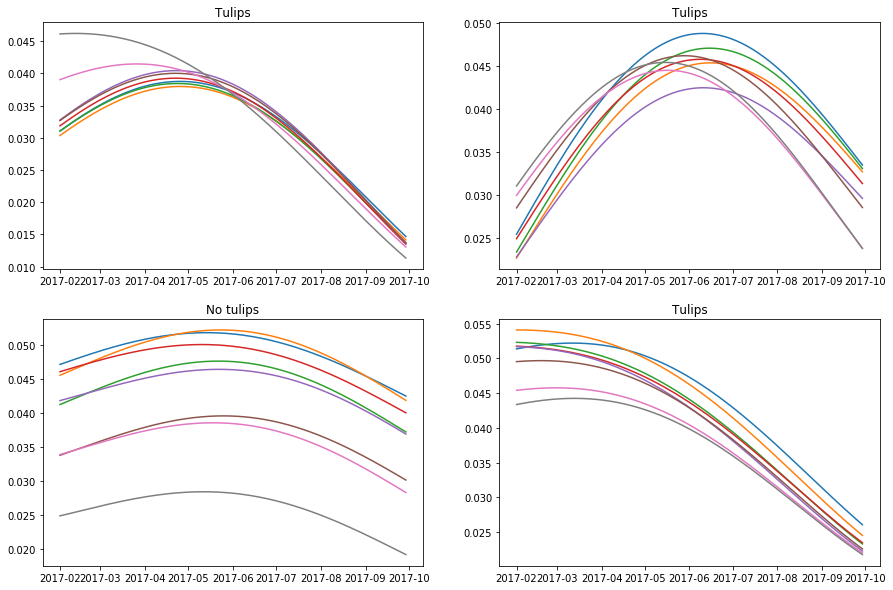

In [43]:
tss, datttt = pickle.load(open("interpolated_ndvi_kriging", "rb+"))
# Akima
interesting = [[16, 16, 16, 16, 16, 16, 16, 16], [193, 194, 195, 196, 197, 198, 199, 200]]
interesting2 = [[40, 40, 40, 40, 40, 40, 40, 40], [323, 324, 325, 326, 327, 328, 329, 330]]# [[104, 104, 104, 104, 104, 104, 104, 104], [491, 492, 493, 494, 495, 496, 497, 498]]
interesting3 = [[193, 193, 193, 193, 193, 193, 193, 193], [141, 142, 143, 144, 145, 146, 147, 148]] # [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
interesting4 = [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
f = plt.figure(figsize=(15,10))
plt.subplot(221)
for x,y in zip(*interesting):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("Tulips")
    
plt.subplot(222)
for x,y in zip(*interesting2):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("Tulips")

plt.subplot(223)
for x,y in zip(*interesting3):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("No tulips")

plt.subplot(224)
for x,y in zip(*interesting4):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(tss,datttt[:,x,y])
    plt.title("Tulips")
    
plt.savefig("ndvi_time_plots_kriging.png", bbox_inches="tight")


In [197]:
patch_inter, = burek
patch_inter.data["NDVI"].shape, patch_inter.mask["VALID_DATA"].shape

((213, 589, 590, 1), (213, 589, 590, 1))

In [120]:
(patch_inter.mask["VALID_DATA"] == False).sum()

0

363 589 590
346 376
26 377
58 375
545 392
363 11
243 552
241 8
161 325
548 332
158 527


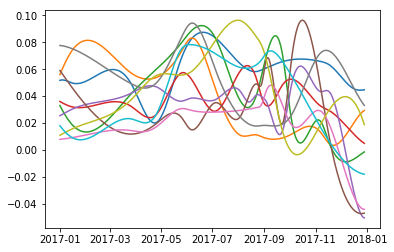

In [183]:
import random

t, w, h, _ = patch_inter.data["NDVI"].shape
print(t, w, h)
for j in range(10):
    x = random.randint(0,w-1)
    y = random.randint(0,h-1)
    print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])

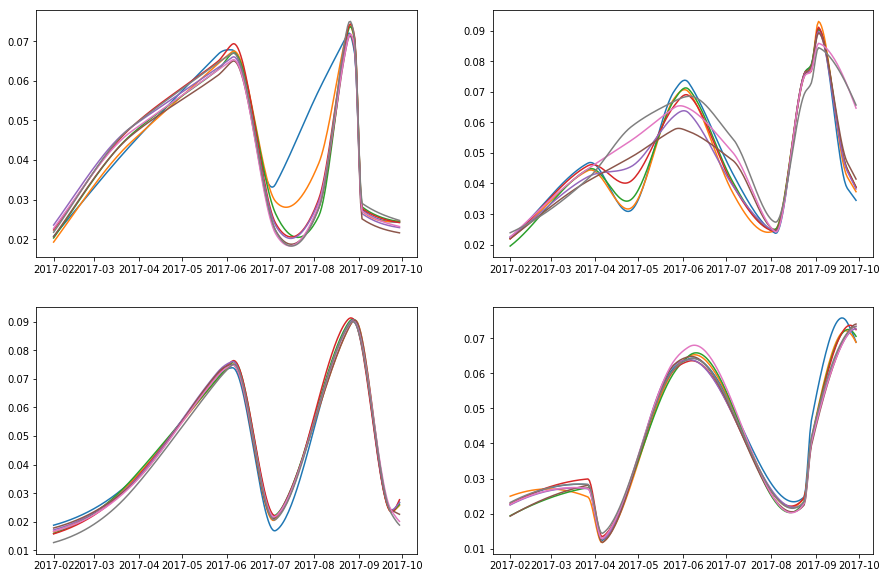

In [229]:
interesting = [ 27,  27,  27,  27,  27,  27,  27,  27],[309, 310, 311, 312, 313, 314, 315, 316]
interesting2 = [[25, 25, 25, 25, 25, 25, 25, 25], [252, 253, 254, 255, 256, 257, 258, 259]]# [[104, 104, 104, 104, 104, 104, 104, 104], [491, 492, 493, 494, 495, 496, 497, 498]]
interesting3 = [[138, 138, 138, 138, 138, 138, 138, 138], [297, 298, 299, 300, 301, 302, 303, 304]]
interesting4 = [[230, 230, 230, 230, 230, 230, 230, 230], [395, 396, 397, 398, 399, 400, 401, 402]]
f = plt.figure(figsize=(15,10))
plt.subplot(221)
for x,y in zip(*interesting):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    
plt.subplot(222)
for x,y in zip(*interesting2):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    
plt.subplot(223)
for x,y in zip(*interesting3):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    
plt.subplot(224)
for x,y in zip(*interesting4):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])

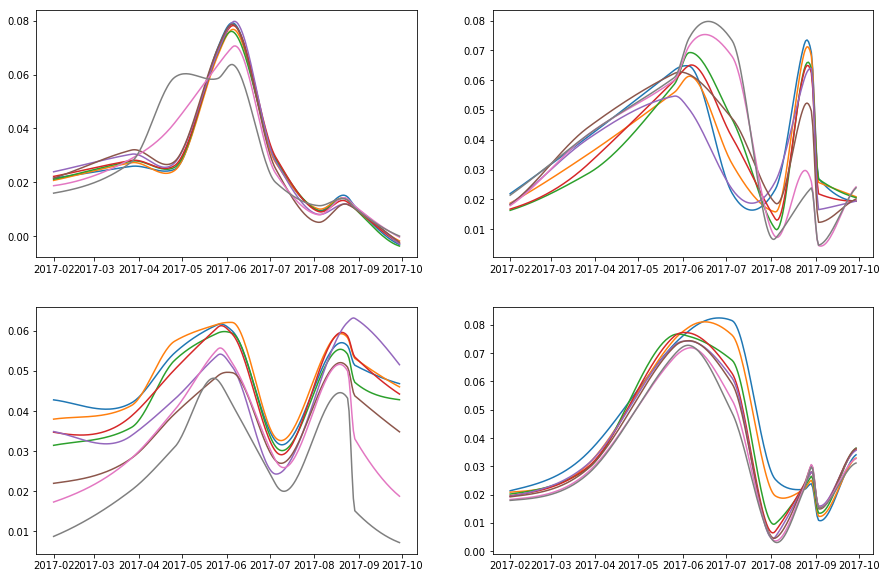

In [231]:
interesting = [[16, 16, 16, 16, 16, 16, 16, 16], [193, 194, 195, 196, 197, 198, 199, 200]]
interesting2 = [[40, 40, 40, 40, 40, 40, 40, 40], [323, 324, 325, 326, 327, 328, 329, 330]]# [[104, 104, 104, 104, 104, 104, 104, 104], [491, 492, 493, 494, 495, 496, 497, 498]]
interesting3 = [[193, 193, 193, 193, 193, 193, 193, 193], [141, 142, 143, 144, 145, 146, 147, 148]] # [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
interesting4 = [[50, 50, 50, 50, 50, 50, 50, 50], [348, 349, 350, 351, 352, 353, 354, 355]]
f = plt.figure(figsize=(15,10))
plt.subplot(221)
for x,y in zip(*interesting):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    
plt.subplot(222)
for x,y in zip(*interesting2):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    
plt.subplot(223)
for x,y in zip(*interesting3):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])
    
plt.subplot(224)
for x,y in zip(*interesting4):
    #x = random.randint(0,w-1)
    #y = random.randint(0,h-1)
    #print(x,y)
    plt.plot(patch_inter.timestamp,patch_inter.data["NDVI"][:,x,y])

In [201]:
patch_inter.timestamp

[datetime.datetime(2017, 3, 1, 0, 0),
 datetime.datetime(2017, 3, 2, 0, 0),
 datetime.datetime(2017, 3, 3, 0, 0),
 datetime.datetime(2017, 3, 4, 0, 0),
 datetime.datetime(2017, 3, 5, 0, 0),
 datetime.datetime(2017, 3, 6, 0, 0),
 datetime.datetime(2017, 3, 7, 0, 0),
 datetime.datetime(2017, 3, 8, 0, 0),
 datetime.datetime(2017, 3, 9, 0, 0),
 datetime.datetime(2017, 3, 10, 0, 0),
 datetime.datetime(2017, 3, 11, 0, 0),
 datetime.datetime(2017, 3, 12, 0, 0),
 datetime.datetime(2017, 3, 13, 0, 0),
 datetime.datetime(2017, 3, 14, 0, 0),
 datetime.datetime(2017, 3, 15, 0, 0),
 datetime.datetime(2017, 3, 16, 0, 0),
 datetime.datetime(2017, 3, 17, 0, 0),
 datetime.datetime(2017, 3, 18, 0, 0),
 datetime.datetime(2017, 3, 19, 0, 0),
 datetime.datetime(2017, 3, 20, 0, 0),
 datetime.datetime(2017, 3, 21, 0, 0),
 datetime.datetime(2017, 3, 22, 0, 0),
 datetime.datetime(2017, 3, 23, 0, 0),
 datetime.datetime(2017, 3, 24, 0, 0),
 datetime.datetime(2017, 3, 25, 0, 0),
 datetime.datetime(2017, 3, 26, 0,

In [ ]:
patch_inter.data["NDVI"].shape, patch_inter.data["NDVI_old"].shape

In [126]:
patch.data["NDVI"].flatten()

NameError: name 'patch' is not defined

In [88]:
np.isnan(patch_inter.data["NDVI"].flatten()).sum()

0

In [42]:
len(patch_inter.timestamp), patch_inter.data["NDVI"].shape

(973, (973, 589, 589, 1))

In [90]:
dat = patch_inter.data["NDVI"][:,249,307]

tims = np.array(patch_inter.timestamp)[~np.isnan(dat.flatten())]
dvec = np.vectorize(lambda x: x.days)
tims2 = dvec(tims - tims[0])

In [99]:
np.any(np.isnan(dat))

True

In [95]:
dat

array([[            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [            nan],
       [    

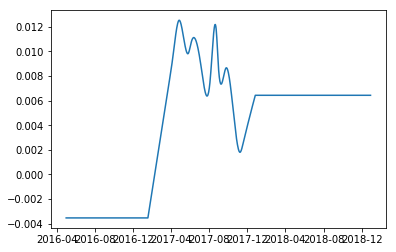

In [98]:
plt.plot(patch_inter.timestamp, np.interp(dvec(np.array(patch_inter.timestamp) - tims[0]),tims2, dat[~np.isnan(dat.flatten())].flatten()))

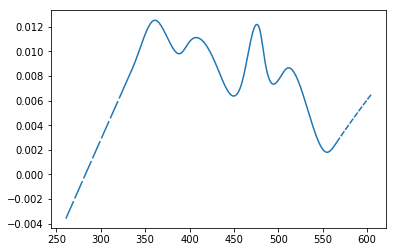

In [43]:
plt.plot(patch_inter.data["NDVI"][:,249,307])

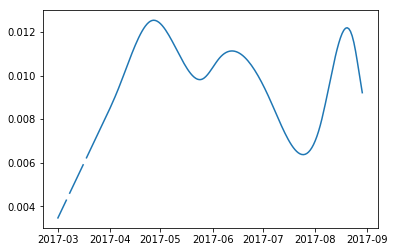

In [16]:
plt.plot(patch_inter.timestamp, patch_inter.data["NDVI"][:,249,307])

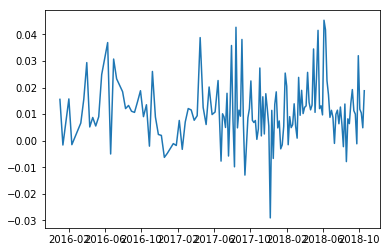

In [41]:
plt.plot(eopatch.timestamp, eopatch.data["NDVI"][:,249,307])

In [144]:
patch_inter.data["NDVI"][:,249,307]

array([[0.00493602],
       [0.00521718],
       [0.00554682],
       [0.00592688],
       [0.00635936],
       [0.00684621],
       [0.00738942],
       [0.00799116],
       [0.00865815],
       [0.00940172],
       [0.01021619],
       [0.01102721],
       [0.01174324],
       [0.01227276],
       [0.01252425],
       [0.01243823],
       [0.01208355],
       [0.01156108],
       [0.01097174],
       [0.0104164 ],
       [0.00999597],
       [0.00981133],
       [0.00995629],
       [0.01036127],
       [0.01079337],
       [0.0110558 ],
       [0.01112472],
       [0.01101954],
       [0.01075965],
       [0.01036445],
       [0.00985336],
       [0.00924576],
       [0.00856237],
       [0.00785442],
       [0.00720356],
       [0.0066928 ],
       [0.00640514],
       [0.00642359],
       [0.00683115],
       [0.00771081],
       [0.00906092],
       [0.01054113],
       [0.01172645],
       [0.01219187],
       [0.01151238],
       [0.00967585],
       [0.00816167],
       [0.007

In [232]:
from debug_testing import AddTemporalDataFeaturesTask

In [233]:
extractor = AddTemporalDataFeaturesTask(mask_data="VALID_DATA")
load_inter = LoadFromDisk('interpolated_1y_2y_artc')
save_extract = SaveToDisk('extracted_1y_1days_artc')

In [234]:
workflow_extract = EOWorkflow(dependencies=[Dependency(transform=load_inter, inputs=[]),
                                            Dependency(transform=extractor, inputs=[load_inter],),
                                            Dependency(transform=save_extract, inputs=[extractor])
                                          ])

In [235]:
results_feature = workflow_extract.execute({load_inter:{'eopatch_folder':'patch'}, save_extract: {'eopatch_folder': 'patch'}})

WORKING
0 3.0040740966796875e-05
1 0.35698986053466797
2 0.3396267890930176
3 0.30367398262023926
4 0.3439157009124756
5 0.31537795066833496
6 0.3753490447998047
7 0.4052600860595703
8 0.331942081451416
9 0.38223910331726074
10 0.40805602073669434
11 0.3312509059906006
12 0.33312487602233887
13 0.37381887435913086
14 0.3194291591644287
15 0.3404099941253662
16 0.31719112396240234
17 0.3443741798400879
18 0.31855106353759766
19 0.3551321029663086
20 0.32408881187438965
21 0.33472490310668945
22 0.3092043399810791
23 0.35373616218566895
24 0.29560303688049316
25 0.34972381591796875
26 0.3070368766784668
27 0.3015570640563965
28 0.35073089599609375
29 0.33162593841552734
30 0.2952589988708496
31 0.316892147064209
32 0.3471801280975342
33 0.3125460147857666
34 0.30559206008911133
35 0.3091580867767334
36 0.314288854598999
37 0.3243849277496338
38 0.42017483711242676
39 0.3550288677215576
40 0.3327450752258301
41 0.363278865814209
42 0.4230978488922119
43 0.3794691562652588
44 0.39257407188

355 0.3267052173614502
356 0.336561918258667
357 0.29506587982177734
358 0.31354284286499023
359 0.31341123580932617
360 0.30417895317077637
361 0.31771326065063477
362 0.3188669681549072
363 0.3042328357696533
364 0.3114590644836426
365 0.32041382789611816
366 0.30353689193725586
367 0.3196280002593994
368 0.35007381439208984
369 0.38181376457214355
370 0.3680989742279053
371 0.37905216217041016
372 0.3346579074859619
373 0.40289998054504395
374 0.3702390193939209
375 0.3389859199523926
376 0.33251500129699707
377 0.33750009536743164
378 0.3090219497680664
379 0.31418633460998535
380 0.36832380294799805
381 0.32269811630249023
382 0.3628420829772949
383 0.3969709873199463
384 0.3288309574127197
385 0.34636998176574707
386 0.3591601848602295
387 0.3673281669616699
388 0.3291778564453125
389 0.44524574279785156
390 0.44777488708496094
391 0.38893795013427734
392 0.3135683536529541
393 0.3263859748840332
394 0.3588862419128418
395 0.3137929439544678
396 0.306873083114624
397 0.3363299369

In [236]:
extracted, = results_feature.values()

In [237]:
extracted

EOPatch(
  data: {
    NDVI: <class 'numpy.ndarray'>, shape=(241, 589, 590, 1), dtype=float32
    NDVI_old: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=float32
  }
  mask: {
    CLM: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=uint8
    IS_DATA: <class 'numpy.ndarray'>, shape=(144, 589, 590, 1), dtype=uint8
    VALID_DATA: <class 'numpy.ndarray'>, shape=(241, 589, 590, 1), dtype=bool
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    NDVI_diff_diff: <class 'numpy.ndarray'>, shape=(589, 590, 1), dtype=float64
    NDVI_diff_max: <class 'numpy.ndarray'>, shape=(589, 590, 1), dtype=float64
    NDVI_diff_min: <class 'numpy.ndarray'>, shape=(589, 590, 1), dtype=float64
    NDVI_max_mean_feature: <class 'numpy.ndarray'>, shape=(589, 590, 1), dtype=float64
    NDVI_max_mean_len: <class 'numpy.ndarray'>, shape=(589, 590, 1), dtype=float64
    NDVI_max_mean_surf: <class 'numpy.ndarray'>, shape=(589, 590, 1), dtype=float64
    NDVI_max_val: <class 'numpy.nd

In [81]:
a = np.zeros((3,3,1)) + 1
b = np.zeros((3,3,1)) + 4
a = a.reshape(3,3,1,1)
b = b.reshape(3,3,1,1)

In [83]:
np.stack([a,b], axis=2).reshape(3,3,2).reshape(9,2)


array([[1., 4.],
       [1., 4.],
       [1., 4.],
       [1., 4.],
       [1., 4.],
       [1., 4.],
       [1., 4.],
       [1., 4.],
       [1., 4.]])

In [238]:
e = extractor
names = [e.max_val_feature, e.min_val_feature, e.mean_val_feature, e.sd_val_feature, 
         e.diff_min_feature, e.diff_max_feature, e.diff_diff_feature, e.max_mean_feature, e.max_mean_len_feature, 
         e.max_mean_surf_feature, e.pos_surf_feature, e.pos_len_feature, e.pos_rate_feature, e.neg_surf_feature, 
         e.neg_len_feature, e.neg_rate_feature, e.pos_transition_feature, e.neg_transition_feature]

In [239]:
len(names)
names

['NDVI_max_val',
 'NDVI_min_val',
 'NDVI_mean_val',
 'NDVI_sd_val',
 'NDVI_diff_min',
 'NDVI_diff_max',
 'NDVI_diff_diff',
 'NDVI_max_mean_feature',
 'NDVI_max_mean_len',
 'NDVI_max_mean_surf',
 'NDVI_pos_surf',
 'NDVI_pos_len',
 'NDVI_pos_rate',
 'NDVI_neg_surf',
 'NDVI_neg_len',
 'NDVI_neg_rate',
 'NDVI_pos_tran',
 'NDVI_neg_tran']

In [240]:
_,w,h,_= extracted.data["NDVI"].shape
data_full = np.stack([extracted.data_timeless[j] for j in names], axis=2).reshape(w,h, len(names))

In [241]:
data_full.shape

(589, 590, 18)

In [242]:
import pickle
pickle.dump(data_full, open("data_full2_artc.pickle", "wb"))

In [96]:
import geopandas as gpd
from tqdm import tqdm_notebook as tqdm